# End to End Matching Baseline

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Loading Test Data

In [6]:
from entity_embed.benchmarks import AmazonGoogleBenchmark

benchmark = AmazonGoogleBenchmark(data_dir_path="data/")
benchmark

13:08:05 INFO:Extracting Amazon-Google...
13:08:05 INFO:Reading Amazon-Google record_dict...
13:08:05 INFO:Reading Amazon-Google train.csv...
13:08:05 INFO:Reading Amazon-Google valid.csv...
13:08:05 INFO:Reading Amazon-Google test.csv...


<AmazonGoogleBenchmark> from http://pages.cs.wisc.edu/~anhai/data1/deepmatcher_data/Structured/Amazon-Google/amazon_google_exp_data.zip

In [7]:
record_dict = benchmark.record_dict
train_record_dict = benchmark.train_record_dict
valid_record_dict = benchmark.valid_record_dict
test_record_dict = benchmark.test_record_dict
train_pos_pair_set = benchmark.train_pos_pair_set
valid_pos_pair_set = benchmark.valid_pos_pair_set
test_pos_pair_set = benchmark.test_pos_pair_set
train_found_pair_set = benchmark.train_pos_pair_set | benchmark.train_neg_pair_set
valid_found_pair_set = benchmark.valid_pos_pair_set | benchmark.valid_neg_pair_set
test_found_pair_set = benchmark.test_pos_pair_set | benchmark.test_neg_pair_set

## Preprocess

In [8]:
field_list = ['title', 'manufacturer', 'price']

In [9]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    max_tokens = 100
    max_chars = 1000
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = default_tokenizer(s)[:max_tokens]
    return ' '.join(s_tokens)[:max_chars]

for record in record_dict.values():
    for field in field_list:
        record[field] = clean_str(record[field])

## Matching: Compare

Make a dataframe `df` with all records (train, valid, test) to add additional features:

In [10]:
record_dict = {**train_record_dict, **valid_record_dict, **test_record_dict}

In [11]:
import pandas as pd

df = pd.DataFrame.from_dict(record_dict, orient='index')
df = df.drop(columns='id')

In [12]:
df['all'] = df.agg('{0[title]} - {0[manufacturer]} - {0[price]}'.format, axis=1)
df['price'] = pd.to_numeric(df['price'].str.replace(' ', ''), errors='coerce')
df.head(3)

,title,manufacturer,price,__source,cluster,all
465,adobe creative suite cs3 web standard upgrade ...,adobe,399.00,left,50,adobe creative suite cs3 web standard upgrade ...
1789,adobe cs3 production premium upgrade,,822.99,right,364,adobe cs3 production premium upgrade - - 822 ...
204,cisco ios enterprise services complete package...,cisco systems enterprise,NaN,left,1062,cisco ios enterprise services complete package...


Replace all `record_dict`s (train, valid, test) to add additional features:

In [13]:
train_record_dict = df.loc[train_record_dict.keys()].to_dict(orient='index')
valid_record_dict = df.loc[valid_record_dict.keys()].to_dict(orient='index')
test_record_dict = df.loc[test_record_dict.keys()].to_dict(orient='index')

In [14]:
import textdistance as td
import math

def exact_eq(x, y):
    return float(x == y)

def token_ops(func):
    def new_func(x, y):
        return func(x.split(), y.split())    
    return new_func

def abs_diff(x, y):
    return abs(x - y)

def abs_diff_log10(x, y):
    diff = abs_diff(x, y)
    if diff > 1:
        return math.log10(diff)
    else:
        return 0.0

SIM_FUNC_DICT = {
    ("all", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("all", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("all", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("all", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("manufacturer", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("manufacturer", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("manufacturer", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("manufacturer", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("title", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("title", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("title", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("title", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("price", "abs_diff"): abs_diff,
    ("price", "abs_diff_log10"): abs_diff_log10,
}

def record_sim_func(record_pair):
    record_left, record_right = record_pair
    feature_dict = {}
    
    for (field, sim_func_name), sim_func in SIM_FUNC_DICT.items():
        x = record_left[field]
        y = record_right[field]
        if x and y:
            if sim_func_name.startswith('abs_diff') and (math.isnan(x) or math.isnan(y)):
                sim = -1.0
            else:
                sim = sim_func(x, y)
        else:
            sim = -1.0
        feature_dict[f"{field}_{sim_func_name}"] = sim
    
    return feature_dict

In [15]:
%%time

pair = next(iter(test_pos_pair_set))
id_left, id_right = pair
feature_dict = record_sim_func((test_record_dict[id_left], test_record_dict[id_right]))

# display(test_record_dict[id_left], test_record_dict[id_right])
feature_dict

CPU times: user 761 µs, sys: 578 µs, total: 1.34 ms
Wall time: 1.06 ms


{'all_jaccard': 0.65,
 'all_overlap': 0.8666666666666667,
 'all_damerau_levenshtein': 0.7254901960784313,
 'all_jaro_winkler': 0.7564400305576777,
 'manufacturer_jaccard': 1.0,
 'manufacturer_overlap': 1.0,
 'manufacturer_damerau_levenshtein': 1.0,
 'manufacturer_jaro_winkler': 1.0,
 'title_jaccard': 0.625,
 'title_overlap': 1.0,
 'title_damerau_levenshtein': 0.5737704918032787,
 'title_jaro_winkler': 0.7055425448868071,
 'price_abs_diff': 10.08999999999999,
 'price_abs_diff_log10': 1.00389116623691}

In [16]:
from collections import defaultdict
import multiprocessing
from tqdm.auto import tqdm

def compare_pairs(record_dict, found_pair_set):
    all_feature_dict = defaultdict(list)
    chunksize = 100
    tasks = (
        (record_dict[id_left], record_dict[id_right])
        for (id_left, id_right)
        in found_pair_set
    )

    with multiprocessing.Pool() as pool:
        for feature_dict in tqdm(
            pool.imap(record_sim_func, tasks, chunksize=chunksize),
            total=len(found_pair_set)
        ):
            for feature, val in feature_dict.items():
                all_feature_dict[feature].append(val)

        pool.close()
        pool.join()
    
    return pd.DataFrame(all_feature_dict, index=pd.MultiIndex.from_tuples(found_pair_set))

In [17]:
%%time

train_feature_df = compare_pairs(train_record_dict, train_found_pair_set)
assert len(train_feature_df) == len(train_found_pair_set)
len(train_found_pair_set)

  0%|          | 0/6874 [00:00<?, ?it/s]

CPU times: user 223 ms, sys: 122 ms, total: 346 ms
Wall time: 458 ms


6874

In [18]:
%%time

valid_feature_df = compare_pairs(valid_record_dict, valid_found_pair_set)
assert len(valid_feature_df) == len(valid_found_pair_set)
len(valid_found_pair_set)

  0%|          | 0/2293 [00:00<?, ?it/s]

CPU times: user 54.3 ms, sys: 96.8 ms, total: 151 ms
Wall time: 230 ms


2293

In [19]:
%%time

test_feature_df = compare_pairs(test_record_dict, test_found_pair_set)
assert len(test_feature_df) == len(test_found_pair_set)
len(test_found_pair_set)

  0%|          | 0/2293 [00:00<?, ?it/s]

CPU times: user 63.2 ms, sys: 91.1 ms, total: 154 ms
Wall time: 221 ms


2293

## Matching: Compare - TFIDF Feature

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_vectorizer(train_record_dict, valid_record_dict, field='all'):
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2,4),
        min_df=2
    )
    train_valid_record_dict = {**train_record_dict, **valid_record_dict}
    tfidf_vectorizer.fit(record[field] for record in train_valid_record_dict.values())
    return tfidf_vectorizer

tfidf_vectorizer = get_tfidf_vectorizer(train_record_dict, valid_record_dict)
tfidf_vectorizer

TfidfVectorizer(analyzer='char', min_df=2, ngram_range=(2, 4))

In [21]:
import numpy as np

def add_tfidf_feature(tfidf_vectorizer, feature_df, record_dict, found_pair_set, field='all'):
    tfidf_matrix = tfidf_vectorizer.transform(record[field] for record in record_dict.values())

    id_to_idx = {id_: idx for idx, id_ in enumerate(record_dict.keys())}
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    tfidf_sim = tfidf_matrix[left_idx].multiply(tfidf_matrix[right_idx]).sum(axis=1)

    feature_df[f'{field}_tfidf'] = tfidf_sim

In [22]:
%%time

add_tfidf_feature(tfidf_vectorizer, train_feature_df, train_record_dict, train_found_pair_set)

CPU times: user 353 ms, sys: 4.92 ms, total: 358 ms
Wall time: 358 ms


In [23]:
%%time

add_tfidf_feature(tfidf_vectorizer, valid_feature_df, valid_record_dict, valid_found_pair_set)

CPU times: user 191 ms, sys: 0 ns, total: 191 ms
Wall time: 190 ms


In [24]:
%%time

add_tfidf_feature(tfidf_vectorizer, test_feature_df, test_record_dict, test_found_pair_set)

CPU times: user 173 ms, sys: 0 ns, total: 173 ms
Wall time: 173 ms


## Matching: Classify

In [25]:
train_valid_feature_df = pd.concat([train_feature_df, valid_feature_df])
train_valid_feature_df.head(3)

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,manufacturer_jaccard,manufacturer_overlap,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,title_jaccard,title_overlap,title_damerau_levenshtein,title_jaro_winkler,price_abs_diff,price_abs_diff_log10,all_tfidf
465,1789,0.300000,0.6000,0.380282,0.677204,-1.0,-1.0,-1.0,-1.0,0.250000,0.600000,0.339623,0.677568,423.99,2.627356,0.301006
204,1376,0.375000,0.5625,0.336957,0.677550,-1.0,-1.0,-1.0,-1.0,0.437500,0.636364,0.409091,0.737375,-1.00,-1.000000,0.478299
551,1420,0.321429,0.5000,0.470588,0.669510,-1.0,-1.0,-1.0,-1.0,0.238095,0.416667,0.488636,0.656027,250.09,2.398096,0.379999


In [26]:
train_true_y = np.array([pair in train_pos_pair_set for pair in train_found_pair_set], dtype='i4')
valid_true_y = np.array([pair in valid_pos_pair_set for pair in valid_found_pair_set], dtype='i4')
test_true_y = np.array([pair in test_pos_pair_set for pair in test_found_pair_set], dtype='i4')

In [27]:
train_valid_true_y = np.concatenate([train_true_y, valid_true_y])

In [28]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import PredefinedSplit, GridSearchCV

cv = PredefinedSplit(
    np.concatenate([
        np.full(train_true_y.shape[0], -1 ,dtype='i4'),
        np.zeros(valid_true_y.shape[0], dtype='i4')
    ])
)
param_grid = {
    'n_estimators': [10, 100, 200],
    'max_depth': [5, 10, 25, 50, None],
    'min_samples_leaf': [1, 3, 5],
}
clf = RandomForestClassifier(oob_score=True, random_state=random_seed)
clf = GridSearchCV(clf, param_grid, scoring='f1', cv=cv, verbose=10, n_jobs=-1)
clf.fit(train_valid_feature_df, train_valid_true_y);

Fitting 1 folds for each of 45 candidates, totalling 45 fits
CPU times: user 1.5 s, sys: 127 ms, total: 1.62 s
Wall time: 9.76 s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 25, 50, None],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [10, 100, 200]},
             scoring='f1', verbose=10)

In [29]:
clf.best_params_

{'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 100}

In [30]:
clf.best_score_

0.6517412935323382

In [31]:
clf.best_estimator_.oob_score_

0.9320388349514563

In [32]:
feature_importances = dict(zip(train_valid_feature_df.columns, clf.best_estimator_.feature_importances_))
sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)

[('all_tfidf', 0.20560691067782472),
 ('all_overlap', 0.10920011707732877),
 ('title_overlap', 0.09368329886574601),
 ('all_jaccard', 0.08996475115260219),
 ('price_abs_diff', 0.0765477916407968),
 ('price_abs_diff_log10', 0.07154595103154873),
 ('all_damerau_levenshtein', 0.06905055116549962),
 ('all_jaro_winkler', 0.06531430996377492),
 ('title_damerau_levenshtein', 0.0650392018182056),
 ('title_jaccard', 0.06478683820136015),
 ('title_jaro_winkler', 0.06401682384939311),
 ('manufacturer_damerau_levenshtein', 0.008375681444901795),
 ('manufacturer_jaccard', 0.006789841115913512),
 ('manufacturer_jaro_winkler', 0.006006657978703109),
 ('manufacturer_overlap', 0.004071274016400938)]

In [33]:
from sklearn.metrics import accuracy_score

cls_threshold = 0.3
train_valid_pred_y = clf.predict_proba(train_valid_feature_df)
train_valid_pred_y[train_valid_pred_y >= cls_threshold] = 1
train_valid_pred_y[train_valid_pred_y < cls_threshold] = 0
train_valid_pred_y = train_valid_pred_y[:, 1]
accuracy_score(train_valid_pred_y, train_valid_true_y)

0.9965092178466237

In [34]:
from sklearn.metrics import precision_recall_fscore_support

pred_y = clf.predict_proba(test_feature_df)
pred_y[pred_y >= cls_threshold] = 1
pred_y[pred_y < cls_threshold] = 0
pred_y = pred_y[:, 1]
precision_recall_fscore_support(test_true_y, pred_y, labels=[1])

(array([0.65201465]), array([0.76068376]), array([0.70216963]), array([234]))

In [35]:
from ordered_set import OrderedSet
from entity_embed.evaluation import precision_and_recall

cls_found_pair_set = OrderedSet(test_feature_df[pred_y.astype(bool)].index)

precision_and_recall(cls_found_pair_set, test_pos_pair_set)

(0.652014652014652, 0.7606837606837606)

False negatives:

In [36]:
for x, y in list(test_pos_pair_set - cls_found_pair_set)[:5]:
    print(clf.predict_proba(test_feature_df.loc[[(x, y)]]))
    display(df.loc[[x, y]])

[[0.87 0.13]]


,title,manufacturer,price,__source,cluster,all
620,adobe premiere pro cs3,adobe,799.00,left,56,adobe premiere pro cs3 - adobe - 799 . 0
1553,adobe premiere pro cs3,,825.99,right,56,adobe premiere pro cs3 - - 825 . 99


[[1. 0.]]


,title,manufacturer,price,__source,cluster,all
207,crystal reports 11 professional full product f...,business objects,909.66,left,307,crystal reports 11 professional full product f...
2888,crystal reports xi professional edition comple...,,537.57,right,307,crystal reports xi professional edition comple...


[[0.98 0.02]]


,title,manufacturer,price,__source,cluster,all
345,portfolio media kit be syst recovery 7 . 0 win...,symantec,50.00,left,11,portfolio media kit be syst recovery 7 . 0 win...
2883,symantec 11859201 be sys recovery 7 . 0 win sb...,,31.98,right,11,symantec 11859201 be sys recovery 7 . 0 win sb...


[[0.83 0.17]]


,title,manufacturer,price,__source,cluster,all
97,tournament poker 2005,eagle games,20.99,left,806,tournament poker 2005 - eagle games - 20 . 99
3000,eagle games egl 150 tournament poker no limit ...,eagle games,7.95,right,806,eagle games egl 150 tournament poker no limit ...


[[0.99 0.01]]


,title,manufacturer,price,__source,cluster,all
243,money premium 2007 win32 eng na mini box us on...,microsoft,118.46,left,808,money premium 2007 win32 eng na mini box us on...
1504,money prem 2007 cd minibox,microsoft,63.99,right,808,money prem 2007 cd minibox - microsoft - 63 . 99


In [37]:
pair = (620, 1553)
display(test_feature_df.loc[[pair]])
clf.predict_proba(test_feature_df.loc[[pair]])

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,manufacturer_jaccard,manufacturer_overlap,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,title_jaccard,title_overlap,title_damerau_levenshtein,title_jaro_winkler,price_abs_diff,price_abs_diff_log10,all_tfidf
620,1553,0.583333,0.777778,0.75,0.936212,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,26.99,1.431203,0.732483


array([[0.87, 0.13]])

<Figure size 1152x720 with 0 Axes>

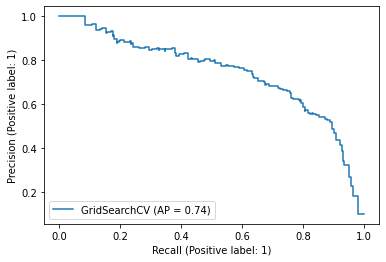

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(16,10))

disp = plot_precision_recall_curve(clf, test_feature_df, test_true_y)